# Radio Modulation with FINN - Notebook #5 of 5

## FPGA setup 
**NOTE**: This notebook is meant to be run on the FPGA. After running the previous notebook, this notebook should be copied to the output directory along with the bitfile and driver files.

Make sure you have setup the FPGA with the PYNQ os correctly installed. 

To copy this notebook from you HOST machine to the FPGA and run ***on the fpga*** (substitute IP with the IP of the FPGA device)
1. `scp -r deploy xilinx@IP:/home/xilinx`
2. `ssh -L 8888:localhost:8888 xilinx@IP`
3. `sudo -E jupyter notebook --port 8888` 
4. Click the URL generated by jupyter notebook to enter jupyter and select this script. 

## Overview

This notebook walks you through how you can run benchmark and verification on the FPGA based on the bitstream and driver generated by FINN.

Overview of the generated files:
- `driver.py`: Description of the FINN-generated accelerator, including the input/output shapes and datatype.<br><br>
- `driver_base.py`: A class designed for FINN dataflow accelerator. This includes many functions such as instantiating the accelerator, running benchmark on an empty input, setting batchsize, executing inputs, ...<br><br>
- `validate.py`: An example validation python script to test run image regconition CNN accelerator. This `validate.py` file is irrelevant to our project, but it gives us a good example on how to instantiate and run validation on accelerator. Instead, we will use this notebook as a replacement for running benchmark and validation.<br><br>
- `[model_name].bit`: The generated Bitfile from synthesis depending on the target platform.<br><br>
- `[model_name].hwh`: The generated Hardware Handoff File<br><br>

### **TODO**: more documentation on data preprocesssing. Though since our case is special, where the input is already quantized to 8 bits. We may be able to remove it. However, incase we want to quantize the model down to 4bits, then we need the preprocessing back.

# Initialize the accelerator

The accelerator is Neural Network, but FPGA-ified! Specifically, the accelerator is simply a python wrapper around the bitstream we generated in the previous steps. This allows use to then treat the accelerator object as our model to achieve high performancer (higher than cpu) modulation classification by using the FPGA design! 

### Remember to install the following dependencies:

In [1]:
# ! apt-get update -y
# ! apt-get install libhdf5-dev -y
# ! pip3 install versioned-hdf5

In [2]:
!export XILINX_XRT=/usr

from finn_examples import models
# Note: the RadioML example is only available on the ZCU104 at the moment
import pynq
from pynq import PL
from driver import io_shape_dict
from driver_base import FINNExampleOverlay
import numpy as np
import math
import pickle
import os
import h5py
from pathlib import Path

PL.reset() #Ensure pynq clear cached hwh

In [3]:
accel=  FINNExampleOverlay(
        bitfile_name="./finn-accel.bit",#change this to your bitfile name
        platform="zynq-iodma",
        io_shape_dict=io_shape_dict,
        batch_size=1,
        runtime_weight_dir="runtime_weights/",
        fclk_mhz=310.0
    )   

In [4]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal()), str(accel.idt())))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal()), str(accel.odt())))

# Load RadioML 2021 dataset

In [5]:
#Change this to your dataset directory
dataset = Path("./RADIOML_2021_07_INT8.hdf5")
assert dataset.is_file()
print(dataset)

In [6]:
h5_file = h5py.File(dataset,'r')

data_h5 = h5_file['X']
label_mod = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
label_snr = h5_file['Z'][:,0]

# assemble list of test set indices
# do not pre-load large dataset into memory
np.random.seed(2021)
test_indices = []
for mod in range(0, 27): #all modulations (0 to 26)
    for snr_idx in range(0, 26): #all SNRs (0 to 25 = -20dB to +30dB)
        start_idx = 26*4096*mod + 4096*snr_idx
        indices_subclass = list(range(start_idx, start_idx+4096))

        split = int(np.ceil(0.1 * 4096)) #90%/10% split
        np.random.shuffle(indices_subclass)
        train_indices_subclass, val_indices_subclass = indices_subclass[split:], indices_subclass[:split]

        #Lower bound of SNR included in test set.
        # >=0 means all SNRs,
        # >=25 means only 30db.
        #Note that SNRS is from -20 to +30 with steps of 2
        if snr_idx >= 0: #select which SNRs to test on 
            test_indices.extend(val_indices_subclass)

test_indices = sorted(test_indices)

mod_classes = [
                "OOK",
                "4ASK",
                "8ASK",
                "BPSK",
                "QPSK",
                "8PSK",
                "16PSK",
                "32PSK",
                "16APSK",
                "32APSK",
                "64APSK",
                "128APSK",
                "16QAM",
                "32QAM",
                "64QAM",
                "128QAM",
                "256QAM",
                "AM-SSB-WC",
                "AM-SSB-SC",
                "AM-DSB-WC",
                "AM-DSB-SC",
                "FM",
                "GMSK",
                "OQPSK",
                "BFSK",
                "4FSK",
                "8FSK",
            ]
snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB

In [7]:
print(data_h5.shape)
print(label_mod.shape)
print(label_snr.shape)
print(len(test_indices))

# Inspect a single frame

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

# Inspect a frame
mod = 12 # 0 to 26
snr_idx = 25 # 0 to 25 = -20dB to +30dB
sample = 123 # 0 to 4095
#-----------------------#
idx = len(snr_classes)*4096*mod + 4096*snr_idx + sample
data, mod, snr = data_h5[idx], label_mod[idx], label_snr[idx]
plt.figure()
plt.plot(data)
print("Modulation: %s, SNR: %.1f dB" % (mod_classes[mod], snr))

# Input quantization
Quantize input data on-the-fly in software before feeding it to the accelerator. Use the uniform quantization range on which the model was trained.

In [9]:
raw_dataset_bit_width=8
model_bit_width=8

raw_dataset_min=- (2.0**(raw_dataset_bit_width-1))
raw_dataset_max=-raw_dataset_min-1
raw_dataset_range=abs(raw_dataset_max-raw_dataset_min)+1

new_min=-(2.0**(model_bit_width-1))
new_max=-new_min-1
new_range=abs(new_max-new_min)+1

print(raw_dataset_min,' ',raw_dataset_max,' ',raw_dataset_range)
print(new_min,' ',new_max,' ',new_range)
def quantize(data):
    normalized_data=(data-raw_dataset_min)/raw_dataset_range
    scaled_data=np.round(normalized_data*new_range)+new_min
    data_quant=np.clip(scaled_data,new_min,new_max)
    # data_quant=data
    data_quant = data_quant.astype(np.int8)
    return data_quant

# Classify a single frame

In [10]:
accel_in = quantize(data).reshape(accel.ishape_normal())
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

In [11]:
accel_out = accel.execute(accel_in)

In [12]:
print("Result: " + str(accel_out))
print("Top-1 class predicted by the accelerator: " + mod_classes[int(accel_out)])

In [13]:
%%timeit
accel_out = accel.execute(accel_in)

# Validate accuracy on entire test set

In [14]:
batch_size = 1024
accel.batch_size = batch_size
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed()), str(accel.oshape_packed())))
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_folded()), str(accel.oshape_folded())))
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_normal()), str(accel.oshape_normal())))

In [15]:
import time
ok = 0
nok = 0
total = len(test_indices)
timer=0

y_exp = np.empty((0))
y_snr = np.empty((0))
y_pred = np.empty((0,len(mod_classes)))

for i_batch in range(math.ceil(total/batch_size)):
    i_frame = i_batch*batch_size
    if i_frame+batch_size > total:
        batch_size = total - i_frame
        accel.batch_size = batch_size
    batch_indices = test_indices[i_frame:i_frame+batch_size]
    data, mod, snr = data_h5[batch_indices], label_mod[batch_indices], label_snr[batch_indices]
    
    
    ibuf = quantize(data).reshape(accel.ishape_normal())
    
    start_time=time.time()
    obuf = accel.execute(ibuf)
    batch_time=time.time()-start_time
    timer+=batch_time
    
    pred = obuf.reshape(batch_size).astype(int)

    ok += np.equal(pred, mod).sum().item()
    nok += np.not_equal(pred, mod).sum().item()
    
    print("batch %d / %d : total OK %d | NOK %d | Time: %.2f seconds" % (i_batch,math.ceil(total/batch_size), ok, nok, batch_time))
    
    y_exp = np.concatenate((y_exp, mod))
    y_snr = np.concatenate((y_snr, snr))
    
    # Convert predicted index to one-hot
    one_hot = np.zeros((batch_size, len(mod_classes)))
    one_hot[np.arange(batch_size), pred] = 1
    y_pred = np.vstack((y_pred, one_hot))
    
print('total time: ',timer,' seconds')

batch 174 / 282 : total OK 105632 | NOK 73568 | Time: 0.36 seconds
batch 175 / 282 : total OK 106392 | NOK 73832 | Time: 0.35 seconds
batch 176 / 282 : total OK 107153 | NOK 74095 | Time: 0.35 seconds
batch 177 / 282 : total OK 107154 | NOK 75118 | Time: 0.35 seconds
batch 178 / 282 : total OK 107184 | NOK 76112 | Time: 0.35 seconds
batch 179 / 282 : total OK 107707 | NOK 76613 | Time: 0.35 seconds
batch 180 / 282 : total OK 108423 | NOK 76921 | Time: 0.35 seconds
batch 181 / 282 : total OK 109258 | NOK 77110 | Time: 0.35 seconds
batch 182 / 282 : total OK 110220 | NOK 77172 | Time: 0.35 seconds
batch 183 / 282 : total OK 111230 | NOK 77186 | Time: 0.35 seconds
batch 184 / 282 : total OK 112231 | NOK 77209 | Time: 0.35 seconds
batch 185 / 282 : total OK 113245 | NOK 77219 | Time: 0.35 seconds
batch 186 / 282 : total OK 114252 | NOK 77236 | Time: 0.35 seconds
batch 187 / 282 : total OK 114674 | NOK 77838 | Time: 0.56 seconds
batch 188 / 282 : total OK 114754 | NOK 78782 | Time: 0.35 sec

In [16]:
accuracy = 100.0 * ok / (total)
print("Overall top-1 accuracy: {}%".format(accuracy))

Overall top-1 accuracy: 64.70189701897019%


## More benchmarking

In [17]:
accel.batch_size = 1024
accel.throughput_test()

{'runtime[ms]': 350.28696060180664,
 'throughput[images/s]': 2923.317494435785,
 'DRAM_in_bandwidth[MB/s]': 5.986954228604488,
 'DRAM_out_bandwidth[MB/s]': 0.002923317494435785,
 'fclk[mhz]': 299.997,
 'batch_size': 1024,
 'fold_input[ms]': 0.08726119995117188,
 'pack_input[ms]': 0.06604194641113281,
 'copy_input_data_to_device[ms]': 2.450227737426758,
 'copy_output_data_from_device[ms]': 0.1347064971923828,
 'unpack_output[ms]': 0.5199909210205078,
 'unfold_output[ms]': 0.06532669067382812}

Overall Accuracy across all SNRs: 64.70%


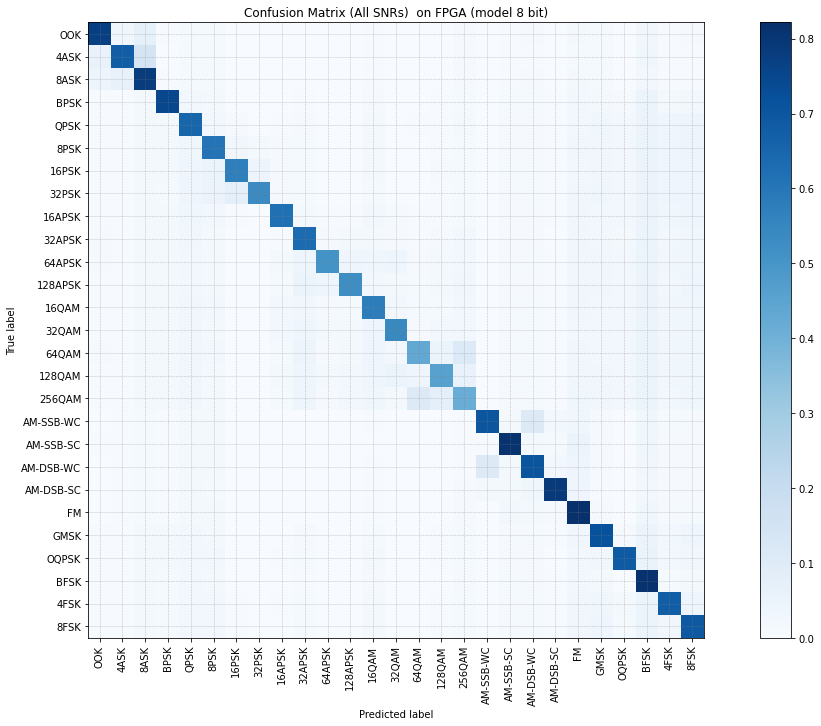

In [18]:
from matplotlib import pyplot as plt
import numpy as np

# Compute confusion matrix
conf = np.zeros([len(mod_classes), len(mod_classes)])
confnorm = np.zeros([len(mod_classes), len(mod_classes)])

for i in range(len(y_exp)):
    true_label = int(y_exp[i])
    pred_label = int(np.argmax(y_pred[i]))
    conf[true_label, pred_label] += 1

# Normalize rows (i.e., divide each row by the total in that row)
for i in range(len(mod_classes)):
    if np.sum(conf[i, :]) > 0:
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])

# Plot confusion matrix
def plot_confusion_matrix(cm, title=f'Confusion Matrix (All SNRs)  on FPGA (model {model_bit_width} bit)', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(16,10),facecolor='white')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(visible=True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    plt.savefig(f'./report/{title.lower().replace(" ","_")}', bbox_inches='tight')
plot_confusion_matrix(confnorm, labels=mod_classes)

# Compute overall accuracy again (for consistency)
correct = np.sum(np.diag(conf))
total = np.sum(conf)
print("Overall Accuracy across all SNRs: {:.2f}%".format(100.0 * correct / total))

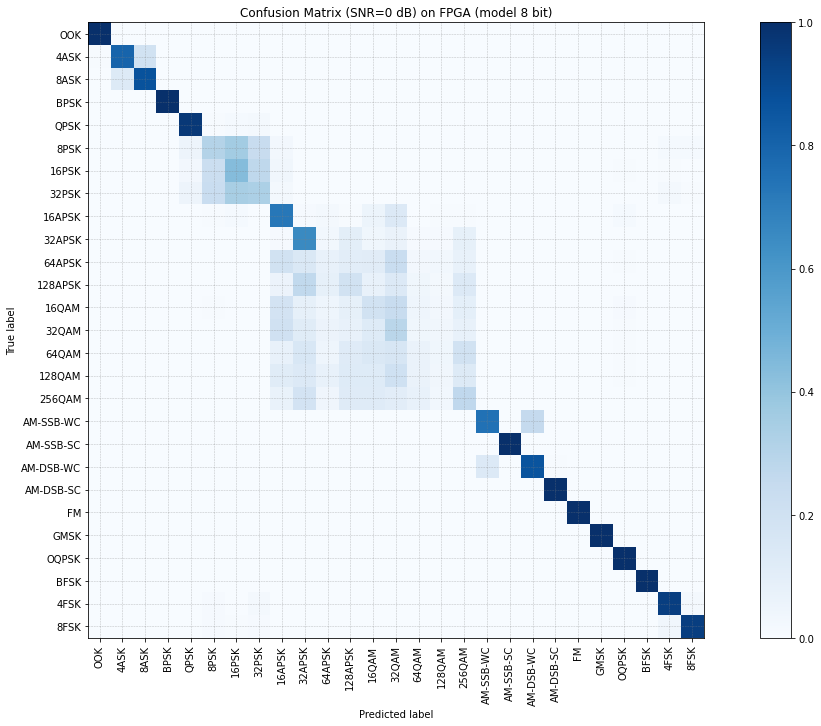

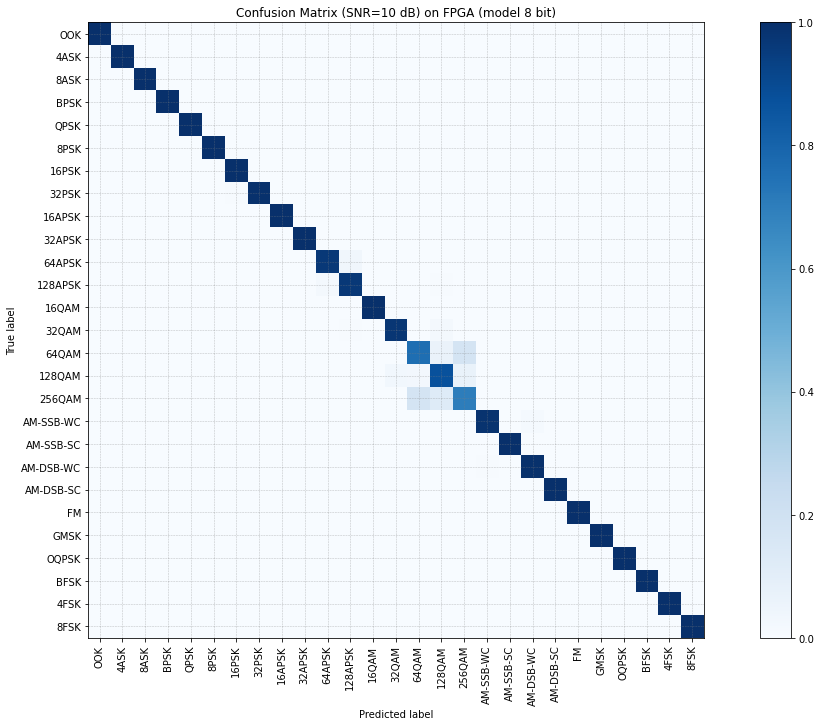

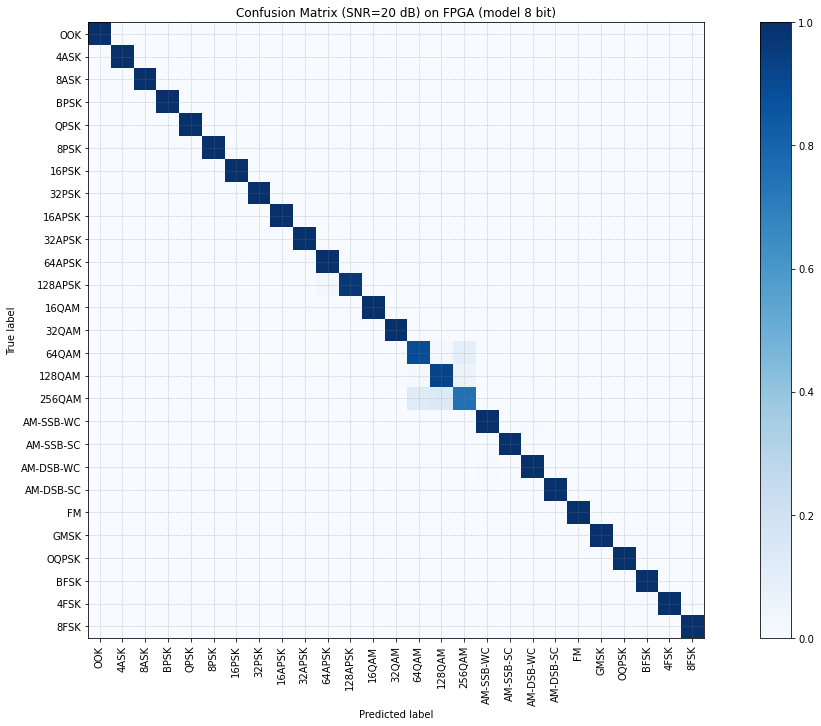

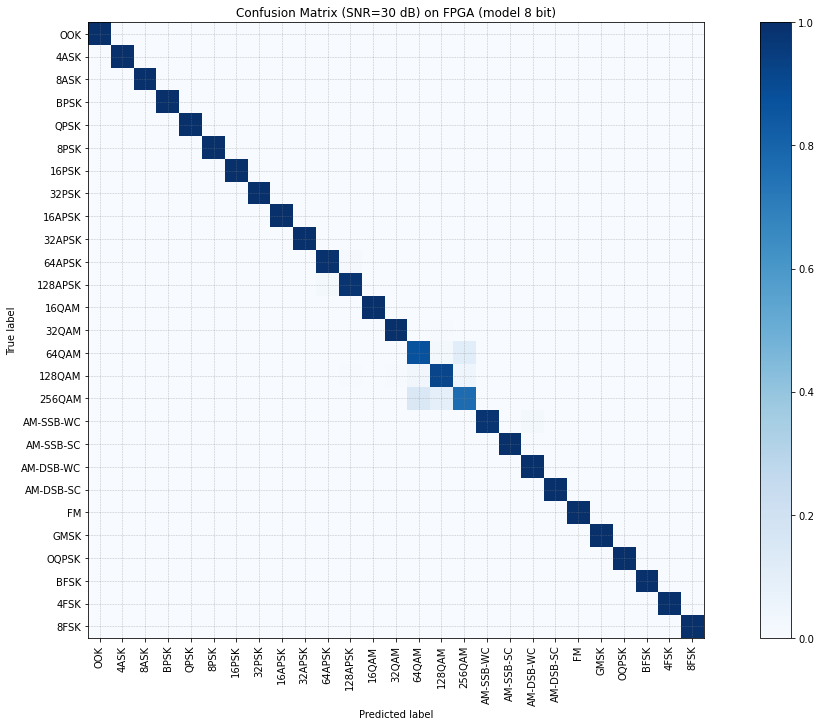

In [20]:
# Loop over SNRs
SNRs_to_plot=[0.0,10.0,20.0,30.0]
unique_snrs = np.unique(y_snr)
acc = []

# We also want to report accuracy above some SNR
snr_index_lb=13    #13 is the index of +6dB
snr_lb_cor=0
snr_lb_total=0

for snr in unique_snrs:
    indices = np.where(y_snr == snr)[0]
    if len(indices) == 0:
        continue

    conf = np.zeros([len(mod_classes), len(mod_classes)])
    confnorm = np.zeros([len(mod_classes), len(mod_classes)])

    for i in indices:
        true_label = int(y_exp[i])
        pred_label = int(np.argmax(y_pred[i]))
        conf[true_label, pred_label] += 1

    for i in range(len(mod_classes)):
        if np.sum(conf[i, :]) > 0:
            confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])

    if snr in SNRs_to_plot:
        plot_confusion_matrix(confnorm, title=f'Confusion Matrix (SNR={int(snr)} dB) on FPGA (model {model_bit_width} bit)', labels=mod_classes)

    correct = np.sum(np.diag(conf))
    total = np.sum(conf)
    acc.append(correct/(total))
    if (snr>=snr_index_lb):
        snr_lb_cor+= correct
        snr_lb_total+= total
    # print(f"SNR {int(snr)} dB - Accuracy: {100.0 * correct / total:.2f}%")

Accuracy @ highest SNR (30.0 dB): 0.981301
Accuracy @ >= SNR(6.0 dB): 0.9802870621298806
Accuracy overall: 0.647019
SNR [-20.0]: 0.04607046070460705
SNR [-18.0]: 0.04372177055103885
SNR [-16.0]: 0.04995483288166215
SNR [-14.0]: 0.06549232158988257
SNR [-12.0]: 0.1018970189701897
SNR [-10.0]: 0.16702800361336947
SNR [-8.0]: 0.24607046070460706
SNR [-6.0]: 0.32827461607949415
SNR [-4.0]: 0.4229448961156278
SNR [-2.0]: 0.5278229448961156
SNR [0.0]: 0.6546522131887985
SNR [2.0]: 0.7246612466124661
SNR [4.0]: 0.8204155374887082
SNR [6.0]: 0.9011743450767841
SNR [8.0]: 0.9506775067750678
SNR [10.0]: 0.9709123757904246
SNR [12.0]: 0.9781391147244806
SNR [14.0]: 0.9793134598012647
SNR [16.0]: 0.9796747967479674
SNR [18.0]: 0.9788617886178862
SNR [20.0]: 0.9818428184281843
SNR [22.0]: 0.9797651309846431
SNR [24.0]: 0.98193315266486
SNR [26.0]: 0.9795844625112918
SNR [28.0]: 0.9803071364046974
SNR [30.0]: 0.9813008130081301


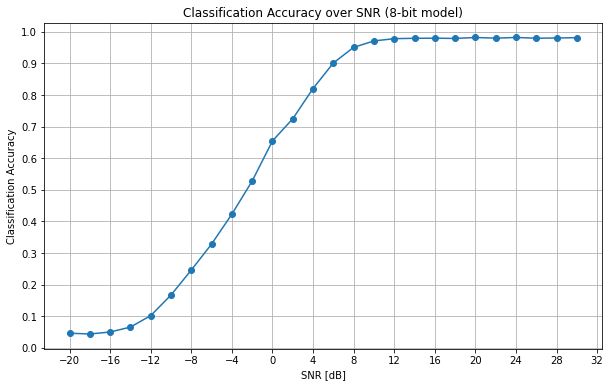

In [22]:
# Plot accuracy over SNR
plt.figure(figsize=(10,6),facecolor='white')
plt.plot(np.arange(-20.0, 30.0+2.0, 2.0), acc, marker='o')
plt.xlabel("SNR [dB]")
plt.xticks(np.arange(-20.0, 30.0+4.0, 4.0))
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
# plt.title("Classification Accuracy over SNR");

title=f"Classification Accuracy over SNR ({model_bit_width}-bit model)"
plt.title(title)
plt.savefig(f'./report/{title.lower().replace(" ","_")}', bbox_inches='tight')

print(f"Accuracy @ highest SNR ({30.0} dB): %f"%(acc[-1]))
print(f"Accuracy @ >= SNR({snr_classes[snr_index_lb]} dB): {snr_lb_cor/snr_lb_total}")
print("Accuracy overall: %f"%(np.mean(acc)))
for i, a in enumerate(acc):
    print(f"SNR [{-20.0 + 2*i}]: {a}")

In [ ]:
accs = []  # List of lists: one per modulation

# Loop over each modulation class
for mod in range(len(mod_classes)):
    accs_mod = []
    for snr in snr_classes:  
        indices = np.where((y_exp == mod) & (y_snr == snr))[0]
        if len(indices) == 0:
            acc = np.nan  # Avoid divide-by-zero
        else:
            y_true_i = y_exp[indices]
            y_pred_i = y_pred[indices]
            acc = np.mean(y_true_i == np.argmax(y_pred_i, axis=1))
        accs_mod.append(acc)
    accs.append(accs_mod)


# Plot accuracy per modulation over SNR
plt.figure(figsize=(12, 8),facecolor='white')

snr_values = np.arange(-20.0, 30.0 + 2.0, 2.0)  

for mod in range(len(mod_classes)):
    acc_curve = accs[mod]
    label = f"{mod}: {mod_classes[mod]}"
    plt.plot(snr_values, acc_curve, marker='o', label=label)

plt.xlabel("SNR [dB]")
plt.xticks(np.arange(-20.0, 30.0 + 4.0, 4.0))
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.tight_layout()

title=f"Classification Accuracy per Modulation over SNR ({model_bit_width}-bit model)"
plt.title(title)
plt.savefig(f'./report/{title.lower().replace(" ","_")}', bbox_inches='tight')

plt.show()
